<a href="https://colab.research.google.com/github/durml91/MMath-Project/blob/duo-branch/Image_Diffusion_(working)/MLP%20Mixer%20diffusion/SDE%20using%20Spiral_Diffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install jaxlib==0.4.2+cuda11.cudnn82 -f  https://storage.googleapis.com/jax-releases/jax_cuda_releases.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.4/164.4 MB 6.2 MB/s eta 0:00:00
  Attempting uninstall: jaxlib
    Found existing installation: jaxlib 0.4.4+cuda11.cudnn82
    Uninstalling jaxlib-0.4.4+cuda11.cudnn82:
      Successfully uninstalled jaxlib-0.4.4+cuda11.cudnn82


In [1]:
!pip install equinox
!pip install optax
!pip install einops
!pip install diffrax

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.7/108.7 KB 4.9 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 2.7.1
    Uninstalling typeguard-2.7.1:
      Successfully uninstalled typeguard-2.7.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.9/154.9 KB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.9/87.9 KB 870.7 kB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 KB 4.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.4/140.4 KB 6.1 MB/s eta 0:00:00


In [2]:
import array
import functools as ft
import gzip
import os
import struct
import urllib.request

import diffrax as dfx  # https://github.com/patrick-kidger/diffrax
import einops  # https://github.com/arogozhnikov/einops
import jax
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import optax  # https://github.com/deepmind/optax

import equinox as eqx
import numpy as np

In [3]:
np.random.seed(2023)
key = jr.PRNGKey(2023)

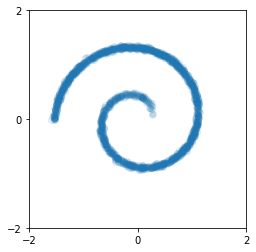

In [4]:
N = 2000

theta = np.sqrt(np.random.rand(N)) * 3 * np.pi  # we generate an array of shape (1024,) such that it they are uniform random numbers in [0,1) and then apply a bunch of operatrions on it
r_a = 0.07 * (2 * theta + np.pi) #mutiply by trig function below by some constant r_a
x = np.array([np.cos(theta) * r_a, np.sin(theta) * r_a]).T #here we produce two rows now of 1024 numbers that have been put through either function respectively - then tranpose so the shape ends up being (1024,2)

x = x + 0.02 * np.random.randn(N, 2) #again we multiply by a bunch of uniform random numbers of the right broadcasting shape

plt.figure().add_subplot(111).set_aspect("equal", adjustable="box")
plt.scatter(x[:, 0], x[:, 1], alpha=0.1) #plot 1st row as x values and 2nd row as y values on the plot
plt.xticks([-2, 0, 2])
plt.yticks([-2, 0, 2])
plt.show()

# Get mean and standard deviation of 'x'
x_mean = x.mean(axis=0)
x_std = x.std(axis=0)

In [8]:
class NeuralNet(eqx.Module):
  main_net: eqx.nn.MLP
  t1: float

  def __init__(self, in_size, out_size, hidden_size, depth, key):
    (rng,) = jr.split(key, 1)
    self.main_net = eqx.nn.MLP(in_size, out_size , hidden_size, depth, key = rng)
    self.t1 = t1

  def __call__(self, t, y):
    t = t / self.t1
    
    t = einops.repeat(t, "1-> 2")
    y = jnp.concatenate([y, t]) #axis =1
    
    y = self.main_net(y)
    return y

In [9]:
def single_loss_fn(model, weight, int_beta, data, t, key):
    mean = data * jnp.exp(-0.5 * int_beta(t))
    var = jnp.maximum(1 - jnp.exp(-int_beta(t)), 1e-5)
    std = jnp.sqrt(var)
    noise = jr.normal(key, data.shape)
    y = mean + std * noise
    t = jnp.array([t])
    pred = model(t, y)
    return weight(t) * jnp.mean((pred + noise / std) ** 2)

In [10]:
def batch_loss_fn(model, weight, int_beta, data, t1, key):
    batch_size = data.shape[0]
    tkey, losskey = jr.split(key)
    losskey = jr.split(losskey, batch_size)
    # Low-discrepancy sampling over t to reduce variance
    t = jr.uniform(tkey, (batch_size,), minval=0, maxval=t1 / batch_size)
    t = t + (t1 / batch_size) * jnp.arange(batch_size)
    loss_fn = ft.partial(single_loss_fn, model, weight, int_beta)
    loss_fn = jax.vmap(loss_fn)
    return jnp.mean(loss_fn(data, t, losskey))

In [72]:
@eqx.filter_jit
def make_step(model, weight, int_beta, data, t1, key, opt_state, opt_update):
    loss_fn = eqx.filter_value_and_grad(batch_loss_fn)
    loss, grads = loss_fn(model, weight, int_beta, data, t1, key)
    updates, opt_state = opt_update(grads, opt_state)
    model = eqx.apply_updates(model, updates)
    key = jr.split(key, 1)[0]
    return loss, model, key, opt_state


In [12]:
t1=10.0
# Optimisation hyperparameters
num_steps=1_000_000
lr=3e-4
batch_size=256
print_every=1_000
# Sampling hyperparameters
dt0=0.1
#sample_size=10
# Seed
seed=2023

In [10]:
key = jr.PRNGKey(seed)
#model_key, train_key, loader_key, sample_key = jr.split(key, 4)

In [ ]:
# data = x
# data_shape = data.shape[1:]

In [ ]:
# model = NeuralNet(4, 2, 512, 4, key)

In [ ]:
# int_beta = lambda t: t
# weight = lambda t: 1 - jnp.exp(-int_beta(t))

In [ ]:
# opt = optax.adabelief(lr)
# opt_state = opt.init(eqx.filter(model, eqx.is_inexact_array))

In [13]:
def dataloader(data, batch_size, *, key):
    dataset_size = data.shape[0]
    indices = jnp.arange(dataset_size)
    while True:
        perm = jr.permutation(key, indices)
        (key,) = jr.split(key, 1)
        start = 0
        end = batch_size
        while end < dataset_size:
            batch_perm = perm[start:end]
            yield data[batch_perm, :]
            start = end
            end = start + batch_size

In [60]:

def single_sample_fn(model, int_beta, data_shape, dt0, t1, key):
    def drift(t, y, args):
        _, beta = jax.jvp(int_beta, (t,), (jnp.ones_like(t),))

        t = jnp.array([t])
        c = -0.5 * beta * (y + model(t, y))

        return c

    term = dfx.ODETerm(drift)
    solver = dfx.Tsit5()
    t0 = 0
    y1 = jr.normal(key, data_shape)
    # reverse time, solve from t1 to t0
    sol = dfx.diffeqsolve(term, solver, t1, t0, -dt0, y1)
    return sol.ys[0]

In [ ]:
# from jax.lax import scan

In [73]:
model_key, train_key, loader_key, sample_key = jr.split(key, 4)
data = x
data_shape = data.shape[1:]

model = NeuralNet(4, 2, 512, 4, key)


int_beta = lambda t: t
weight = lambda t: 1 - jnp.exp(-int_beta(t))  
opt = optax.adabelief(lr)
opt_state = opt.init(eqx.filter(model, eqx.is_inexact_array))

total_value = 0
total_size = 0
losses = [0]
i=0
ls=2


for step, data in zip(range(num_steps), dataloader(data, batch_size, key=loader_key)):
        value, model, train_key, opt_state = make_step(model, weight, int_beta, data, t1, train_key, opt_state, opt.update)
        total_value += value.item()
        total_size += 1

        if (step % print_every) == 0 or step == num_steps - 1:
              
            print(f"Step={step} Loss={total_value / total_size}")
            if step != 0 :
                ls = total_value / total_size
                if jnp.absolute(ls - losses[i]) > 5e-5:
                    i += 1
                    losses.append(ls)
                else:
                    print("Early stopping intervened")
                    break
            else:
                continue
                total_value = 0
                total_size = 0

EinopsError: ignored

In [15]:
from diffrax import diffeqsolve, ControlTerm, Euler, MultiTerm, ODETerm, SaveAt, VirtualBrownianTree, UnsafeBrownianPath

In [24]:
@eqx.filter_jit
def single_sample_fn(model, int_beta, data_shape, dt0, t1, key):
  
  def drift(t, y, args):
    _, beta = jax.jvp(int_beta, (t,), (jnp.ones_like(t),))

    return -0.5*beta*(y+2*model(t,y))

  def diffusion(t, y, args):
    _, beta = jax.jvp(int_beta, (t,), (jnp.ones_like(t),)) # gets an array of beta_t applied to an array of shape t
    r = jnp.ones_like(y)
    diff= jnp.sqrt(beta)
    ndf = r * diff

    return ndf
  term = dfx.ODETerm(drift)
  t0=0
  brownian_motion = VirtualBrownianTree(t1, t0, tol=dt0, shape = data_shape, key=key)
  solver = Euler()
  y1 = jr.normal(key, data_shape)
  solver = Euler()
  term = dfx.ODETerm(drift)
  #terms = MultiTerm(ODETerm(drift), ControlTerm(diffusion, brownian_motion))
  
  
  
  sol = dfx.diffeqsolve(term, solver, t1, t0, -dt0, y1)

  #sol = diffeqsolve(terms, solver, t1, t0, -dt0, y1)
  return sol.ys

In [49]:

def single_sample_fn(model, int_beta, data_shape, dt0, t1, key):
    def drift(t, y, args):
        _, beta = jax.jvp(int_beta, (t,), (jnp.ones_like(t),))
        t = jnp.array([t])
        return -0.5 * beta * (y + model(t, y))


    def diffusion(t, y, args):
        _, beta = jax.jvp(int_beta, (t,), (jnp.ones_like(t),)) # gets an array of beta_t applied to an array of shape t
        r = jnp.ones_like(y)
        diff = jnp.sqrt(beta)
        return r*diff
    tl = jnp.sqrt(dt0)
    bkey, ykey = jr.split(key, 2)
    t0 = 0
    drift = dfx.ODETerm(drift)
    brownian_motion = VirtualBrownianTree(t1, t0, tol=tl, shape = data_shape, key=bkey)
    
    terms = MultiTerm(drift, ControlTerm(diffusion, brownian_motion))

    solver = dfx.Heun()
    y1 = jr.normal(ykey, data_shape)
    # reverse time, solve from t1 to t0
    sol = dfx.diffeqsolve(terms, solver, t1, t0, -dt0, y1)
    return sol.ys[0]

In [57]:
sample_key, _ = jr.split(key, 2)

In [28]:
dt0 =0.1

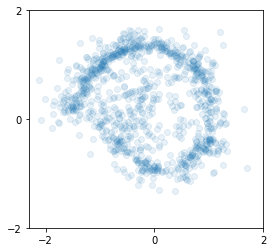

In [61]:
sample_key = jr.split(sample_key, 1_000)
sample_fn = ft.partial(single_sample_fn, model, int_beta, data_shape, dt0, t1)
sample = jax.vmap(sample_fn)(sample_key)
  
plt.figure().add_subplot(111).set_aspect("equal", adjustable="box")
plt.scatter(sample[:, 0], sample[:, 1], alpha=0.1) #plot 1st row as x values and 2nd row as y values on the plot
plt.xticks([-2, 0, 2])
plt.yticks([-2, 0, 2])
plt.show()

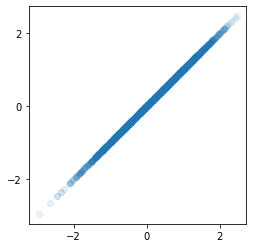

In [23]:
plt.figure().add_subplot(111).set_aspect("equal", adjustable="box")
plt.scatter(sample[:, 0], sample[:, 1], alpha=0.1) #plot 1st row as x values and 2nd row as y values on the plot
plt.xticks([-2, 0, 2])
plt.yticks([-2, 0, 2])
plt.show()

In [67]:
R = 5000
train_ts = jnp.arange(1, R)/(R-1)

#we jit the function, but we have to mark some of the arguments as static,
#which means the function is recompiled every time these arguments are changed,
#since they are directly compiled into the binary code. This is necessary
#since jitted-functions cannot have functions as arguments. But it also 
#no problem since these arguments will never/rarely change in our case,
#therefore not triggering re-compilation.
#@partial(jit, static_argnums=[1,2,3,4,5])
def reverse_sde(rng, N, n_samples, int_beta, score, ts=train_ts):
    """
    rng: random number generator (JAX rng)
    N: dimension in which the reverse SDE runs
    N_initial: How many samples from the initial distribution N(0, I), number
    forward_drift: drift function of the forward SDE (we implemented it above)
    disperion: dispersion function of the forward SDE (we implemented it above)
    score: The score function to use as additional drift in the reverse SDE
    ts: a discretization {t_i} of [0, T], shape 1d-array
    """
    def f(carry, params):
        t, dt = params
        x, rng = carry
        rng, step_rng = jax.random.split(rng)
        disp = int_beta(1-t)
        t = jnp.ones((x.shape[0], 1)) * t
        drift = (-0.5 * int_beta(1-t) * x) + disp * jax.vmap(score)(1-t, x)
        noise = jr.normal(step_rng, x.shape)
        x = x + dt * drift + jnp.sqrt(dt)*disp*noise
        return (x, rng), ()
    
    rng, step_rng = jr.split(rng)
    initial = jr.normal(step_rng, (n_samples, N))
    dts = ts[1:] - ts[:-1]
    params = jnp.stack([ts[:-1], dts], axis=1)
    (x, _), _ = jax.lax.scan(f, (initial, rng), params)
    return x

In [69]:
samples = reverse_sde(key, 2, 1000, int_beta, model)

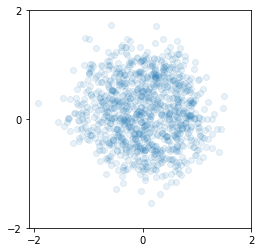

In [70]:
plt.figure().add_subplot(111).set_aspect("equal", adjustable="box")
plt.scatter(samples[:, 0], samples[:, 1], alpha=0.1) #plot 1st row as x values and 2nd row as y values on the plot
plt.xticks([-2, 0, 2])
plt.yticks([-2, 0, 2])
plt.show()

In [ ]:
# @partial(jit, static_argnums=[1,2,3,4,5])
# def reverse_sde(rng, N, n_samples, forward_drift, dispersion, score, ts=train_ts):
#     """
#     rng: random number generator (JAX rng)
#     N: dimension in which the reverse SDE runs
#     N_initial: How many samples from the initial distribution N(0, I), number
#     forward_drift: drift function of the forward SDE (we implemented it above)
#     disperion: dispersion function of the forward SDE (we implemented it above)
#     score: The score function to use as additional drift in the reverse SDE
#     ts: a discretization {t_i} of [0, T], shape 1d-array
#     """
#     def f(carry, params):
#         t, dt = params
#         x, rng = carry
#         rng, step_rng = jax.random.split(rng)
#         disp = dispersion(1-t)
#         t = jnp.ones((x.shape[0], 1)) * t
#         drift = -forward_drift(x, 1-t) + disp**2 * score(x, 1-t)
#         noise = random.normal(step_rng, x.shape)
#         x = x + dt * drift + jnp.sqrt(dt)*disp*noise
#         return (x, rng), ()
    
#     rng, step_rng = random.split(rng)
#     initial = random.normal(step_rng, (n_samples, N))
#     dts = ts[1:] - ts[:-1]
#     params = jnp.stack([ts[:-1], dts], axis=1)
#     (x, _), _ = scan(f, (initial, rng), params)
#     return x

In [ ]:
def log_q_t_z(t, z=x):
    # t: scalar timestep
    # z: [B, D], points to evaluate on - theis comes from the meshgrid
    # x: [N, D], dataset
    # D: data dimensionality
    # var_t = jax.nn.sigmoid(beta(t))[None, None, None] #simply produces an array of one particular value
    # means_t = jnp.sqrt(1.0 - var_t) * x[None, :, :] 
    var_t = jax.nn.sigmoid(int_beta(t))
    var_t = einops.rearrange(var_t, "  -> 1 1 1")

    
    nx = einops.rearrange(x, " n d -> 1 n d")
    means_t = jnp.sqrt(1.0 - var_t)*nx

    nz  = einops.rearrange(z, "b d -> b 1 d")
    
    log_q = (nz - means_t) ** 2 / var_t + jnp.log(var_t * 2 * jnp.pi)
    #print(log_q.shape)
    log_q *= -0.5
    
    
    #log_q = log_q.sum(axis=2) 
    log_q = einops.reduce(log_q, "b n d -> b n", "sum")#essentially gets rid of the last dimension
    #print(log_q.shape)

    # Mixture of Gaussians, N is number of mixture components
    N = x.shape[1] #we should just recover our N which was orginally 1024
    log_q = jax.scipy.special.logsumexp(log_q - jnp.log(N), axis=1)

    return log_q


In [ ]:
f_score = jax.grad(lambda t: log_q_t_z(t).sum()) #so we take the grad not of the function log, but of the mapping! Also this is summing over the array of size (400,) so the output is a scalar

In [ ]:
f_score(4.0).shape

()

In [ ]:

def single_sample_fn(model, int_beta, data_shape, dt0, t1, key):
  
  def drift(t, y, args):
    print(t.shape)
    _, beta = jax.jvp(int_beta, (t,), (jnp.ones_like(t),))  # Push forward the vector `ones_like(t,)` along `int_beta` evaluated at `(t,)`
    print(jnp.ones_like(t))
    c = -0.5*beta*(y+2*model(t,y))
    print(c)
    return c

  # def diffusion(t, y, args):
  #   _, beta = jax.jvp(int_beta, (t,), (jnp.ones_like(t),)) # gets an array of beta_t applied to an array of shape t

  #   sqrtbeta= jnp.sqrt(beta)
  #   test = jnp.ones((2,))
  #   sqrtbeta = sqrtbeta * test
  


  #   return sqrtbeta
  diffusion = lambda t, y, args: jnp.array([jnp.sqrt(2), jnp.sqrt(2)])
  t0=0
  #brownian_motion = dfx.VirtualBrownianTree(t0, t1, tol=1e-3, shape = (1,), key=key)
  brownian_motion = dfx.UnsafeBrownianPath(shape = (2,), key=key)
  y1 = jr.normal(key, data_shape)
  terms = MultiTerm(ODETerm(drift), ControlTerm(diffusion, brownian_motion))
  solver = Euler()

  sol = diffeqsolve(terms, solver, t1, t0, -dt0, y1, adjoint=dfx.DirectAdjoint())
  return sol.ys[0]

In [ ]:
jnp.array([jnp.sqrt(2), jnp.sqrt(2)])

Array([1.4142135, 1.4142135], dtype=float32)

In [ ]:
tref = jnp.array([2])

()

In [ ]:
somef = lambda r: r^2

In [ ]:
f = jnp.array(4)

In [ ]:
from jax import jvp

# Isolate the function from the weight matrix to the predictions
f = lambda W: predict(W, b, inputs)

key, subkey = random.split(key)
v = random.normal(subkey, W.shape)

# Push forward the vector `v` along `f` evaluated at `W`
y, u = jvp(f, (W,), (v,))

In [ ]:
(jnp.ones_like(f, dtyp), )

NameError: ignored

In [ ]:
(f, )

(Array(4, dtype=int32, weak_type=True),)

In [ ]:
from jax import dtypes

In [ ]:
primals, tangents = jax.jvp(somef, (f,), (jnp.ones_like(f, dtype = dtypes.float0),))

TypeError: ignored

In [ ]:
model_key, train_key, loader_key, sample_key = jr.split(key, 4)

In [ ]:
dt0 = 0.01

In [ ]:
f = jnp.array(4.0)

In [ ]:
f.shape

()

In [ ]:
_, beta = jax.jvp(int_beta, (f,), (jnp.ones_like(f),))

In [ ]:
beta

Array(1., dtype=float32, weak_type=True)

In [ ]:
single_sample_fn(model, int_beta, data_shape, dt0, t1, key)

()
Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=2/0)>
Traced<ShapedArray(float32[2])>with<DynamicJaxprTrace(level=2/0)>


Array([1.1014693, 1.2227552], dtype=float32, weak_type=True)

In [ ]:
model_key, train_key, loader_key, sample_key = jr.split(key, 4)

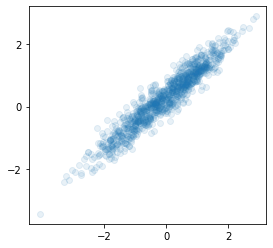

In [ ]:
sample_key = jr.split(sample_key, 1_000)
sample_fn = ft.partial(single_sample_fn, model, int_beta, data_shape, dt0, t1)
sample = jax.vmap(sample_fn)(sample_key)
  
plt.figure().add_subplot(111).set_aspect("equal", adjustable="box")
plt.scatter(sample[:, 0], sample[:, 1], alpha=0.1) #plot 1st row as x values and 2nd row as y values on the plot
plt.xticks([-2, 0, 2])
plt.yticks([-2, 0, 2])
plt.show()

In [ ]:
from jax.lax import scan

In [ ]:
train_ts = jnp.arange(1, t1)/(t1-1)

def reverse_sde(sample_key, dim, n_samples, int_beta, model, ts=train_ts):
   
    def f(carry, params):
        t, dt = params
        x, key = carry
        key1, key2 = jax.random.split(key)
        fbeta = int_beta(1-t)
        t = jnp.ones((x.shape[0], 1)) * t
      
        noise = jr.normal(step_rng, x.shape)
        

        x = x + 1/2 * (1-t) * (x + 2*model(x,t))*dt + (jnp.sqrt(fbeta(t)* dt)*noise)
        
        return (x, rng), ()
    
    rng, step_rng = jr.split(sample_key, 2)
    initial = jr.normal(step_rng, (n_samples, dim))
    dts = ts[1:] - ts[:-1]
    params = jnp.stack([ts[:-1], dts], axis=1)
    (x, _), _ = scan(f, (initial, key), params)
    return x

In [ ]:
dts = train_ts[1:] - train_ts[:-1]
params = jnp.stack([train_ts[:-1], dts], axis=1)

In [ ]:
def reverse_sde(sample_key, dim, n_samples, int_beta, model, ts=train_ts):


    dts = train_ts[1:] - train_ts[:-1]
    params = jnp.stack([train_ts[:-1], dts], axis=1)

    initial = jr.normal(sample_key, (n_samples, dim))
    

In [ ]:
reverse_sde(key, 2, 100, int_beta, model, ts=train_ts)

EinopsError: ignored

In [ ]:
dt0 = 1

In [ ]:
def reverse(model, int_beta, data_shape, dt0, t1, key):

    x = jr.normal(key, data_shape)
    T = t1//dt0
    T = jnp.array(T, dtype=int)
    cm = dt0
    for a in range(100):
        epsilon = jr.normal(key, data_shape)
        ct = t1-cm
        ct = jnp.array(ct)
        x = x + 1/2 * int_beta(ct) * (x + 2*model(ct,x)) * dt0 + jnp.sqrt(int_beta(ct) * dt0) * epsilon
        cm += dt0

    return x

In [ ]:
reverse(model, int_beta, data_shape, dt0, t1, key)

Array([ 0.1722902, -2.7949548], dtype=float32)

In [ ]:
model_key, train_key, loader_key, sample_key = jr.split(key, 4)

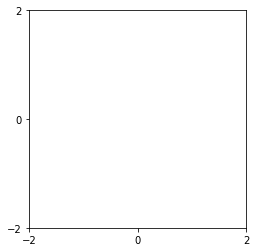

In [ ]:
sample_key = jr.split(sample_key, 1_000)
sample_fn = ft.partial(reverse, model, int_beta, data_shape, dt0, t1)
sample = jax.vmap(sample_fn)(sample_key)
  
plt.figure().add_subplot(111).set_aspect("equal", adjustable="box")
plt.scatter(sample[:, 0], sample[:, 1], alpha=0.1) #plot 1st row as x values and 2nd row as y values on the plot
plt.xticks([-2, 0, 2])
plt.yticks([-2, 0, 2])
plt.show()